In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import datetime

In [20]:
df = pd.read_csv('assets/metadados.csv')

In [21]:
y = df['classificacao'].values.tolist()

In [22]:
X = []
img_paths = df['arquivo'].values.tolist()
for img_path in img_paths:
    img = tf.keras.preprocessing.image.load_img('assets/'+img_path, target_size=(128, 128))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.image.rgb_to_grayscale(img_array)
    X.append(img_array)

In [23]:
X = np.array(X, dtype=np.float32) / 255.0
y = np.array(y, dtype=np.float32)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
len(X_test)

10

In [26]:
datagen = ImageDataGenerator(
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.07,
    fill_mode='nearest'
)

train_generator = datagen.flow(X_train, y_train, batch_size=16)

In [27]:
save_dir = "assets/augmented_images"
os.makedirs(save_dir, exist_ok=True)

for i, (img, label) in enumerate(datagen.flow(X, y, batch_size=1, save_to_dir=save_dir, save_prefix='aug', save_format='jpg')):
    if i >= 50:
        break


In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# model.fit(train_generator, epochs=50, batch_size=16, validation_data=(X_test, y_test))


/home/blansk/miniconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
len(X_test), len(y_test), len(X_train), len(y_train)

(10, 10, 36, 36)

In [30]:
def lr_scheduler(epoch, lr):
    if epoch % 10 != 0:
        return lr
    else:
        return lr * 0.9


lr_schedule = LearningRateScheduler(lr_scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history = model.fit(train_generator, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping, lr_schedule])

Epoch 1/50


/home/blansk/miniconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - accuracy: 0.6278 - loss: 1.3370 - val_accuracy: 0.6000 - val_loss: 0.6623 - learning_rate: 9.0000e-04
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.5217 - loss: 1.0261 - val_accuracy: 0.6000 - val_loss: 0.6765 - learning_rate: 9.0000e-04
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.4115 - loss: 1.0575 - val_accuracy: 0.6000 - val_loss: 0.6915 - learning_rate: 9.0000e-04
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.5547 - loss: 0.6854 - val_accuracy: 0.6000 - val_loss: 0.6930 - learning_rate: 9.0000e-04
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.5278 - loss: 0.6726 - val_accuracy: 0.6000 - val_loss: 0.6927 - learning_rate: 9.0000e-04
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.6163 - loss: 0.6694 - val_accuracy: 0.6000 - val_loss: 0.6907 - learning_rate: 9.0000e-04
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.5538 - loss: 0.6637 - v

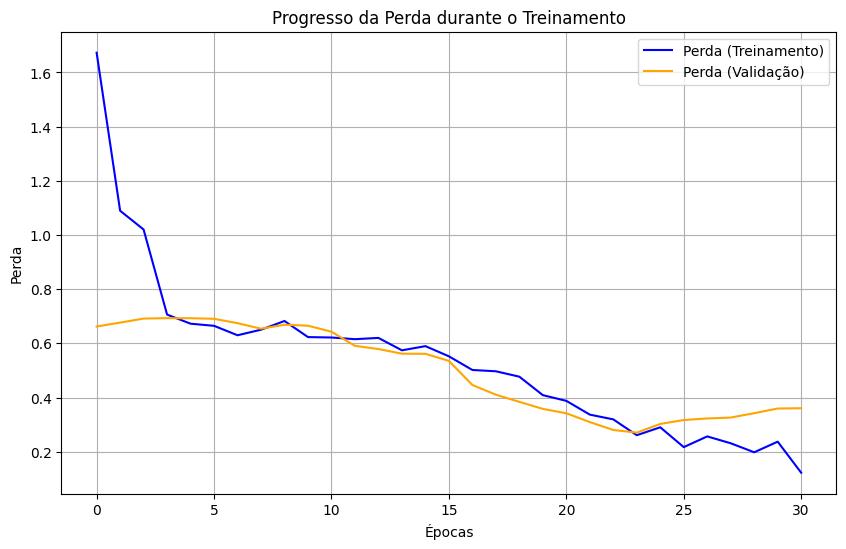

In [31]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Perda (Treinamento)', color='blue')
plt.plot(val_loss, label='Perda (Validação)', color='orange')
plt.title('Progresso da Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()



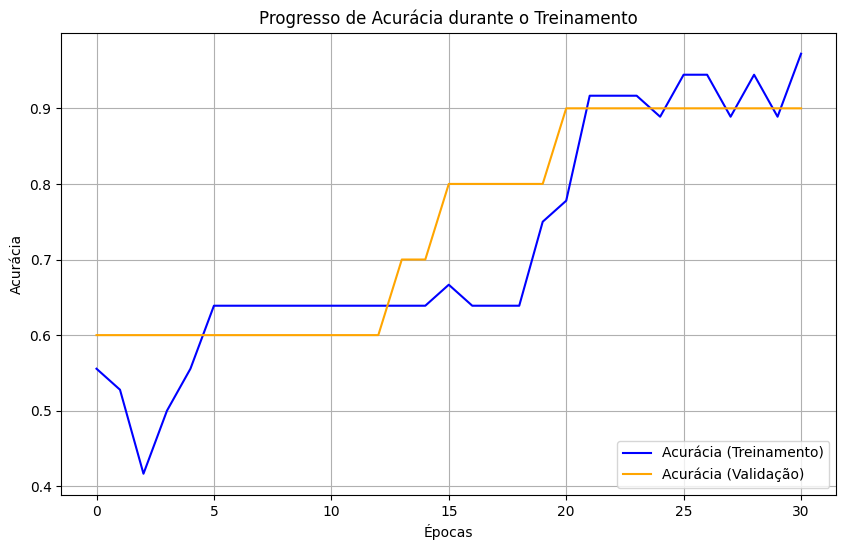

In [32]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(train_accuracy, label='Acurácia (Treinamento)', color='blue')
plt.plot(val_accuracy, label='Acurácia (Validação)', color='orange')
plt.title('Progresso de Acurácia durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [33]:
y_pred = model.predict(X)

y_pred_classes = (y_pred > 0.5).astype("int32")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


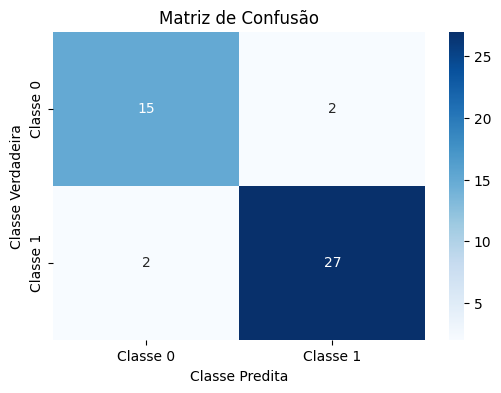

In [34]:
cm = confusion_matrix(y, y_pred_classes)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
plt.title("Matriz de Confusão")
plt.xlabel("Classe Predita")
plt.ylabel("Classe Verdadeira")
plt.show()


In [ ]:
def preprocess_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.image.rgb_to_grayscale(img_array) 
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

test_img_path = "assets/images/40.png"
X_test = preprocess_image(test_img_path)
prediction = model.predict(X_test)

if prediction[0] > 0.5:
    print(f"A imagem {test_img_path} é classificada como: VÁLIDA")
else:
    print(f"A imagem {test_img_path} é classificada como: INVÁLIDA")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
A imagem assets/images/40.png é classificada como: INVÁLIDA


In [39]:
now = datetime.datetime.now()
current_time = now.strftime("%Y-%m-%d_%H-%M")
model.save(f'assets/models/model_{current_time}.h5')
